### TODO
1. Setup three models for GOBench dataset
2. Setup three models for DGP dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, json, pickle
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt

import go_bench
from go_bench.load_tools import load_GO_tsv_file, load_protein_sequences, convert_to_sparse_matrix

from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, vstack, hstack
from sklearn.metrics import precision_recall_fscore_support

# device = torch.device('cuda:0')
def get_sparse_probs(model, dataloader, threshold=0.02):
    prot_ids = []
    probs_list = []
    with torch.no_grad():
        for d in dataloader:
            prot_id_l = d["prot_id"]
            X = d["seq"]
            prot_ids.extend(prot_id_l)
            X = X.to(model.device)
            m_probs = model(X)
            torch.sigmoid(m_probs, out=m_probs)
            m_probs = m_probs.cpu().numpy()
            m_probs = np.where(m_probs > threshold, m_probs, 0) #Threshold unlikely predictions to keep output sparse. 
            new_probs = csr_matrix(m_probs, dtype=np.float32)
            probs_list.append(new_probs)
    probs = vstack(probs_list)
    return prot_ids, probs

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support
from go_bench.metrics import threshold_stats

# BLAST Utility Functions

In [2]:
def load_diamond_scores(hit_fn):
    diamond_scores = {}
    with open(hit_fn) as f:
        for line in f:
            it = line.strip().split()
            if it[0] not in diamond_scores:
                diamond_scores[it[0]] = {}
            diamond_scores[it[0]][it[1]] = float(it[2])
    return diamond_scores

def blast_hit_to_pred(train_dict, diamond_scores, pred_ids):
    blast_preds = {}
    for prot_id in pred_ids:
        annots = {}
        if(prot_id in diamond_scores):
            sim_prots = diamond_scores[prot_id] #Similar prots in training
            allgos = set()
            total_score = 0.0
            for pid, score in sim_prots.items():
                allgos |= set(train_dict[pid]) #GO Terms for each similar prot
                total_score += score
            allgos = list(sorted(allgos))
            sim = np.zeros(len(allgos), dtype=np.float32)
            for j, go_id in enumerate(allgos):
                s = 0.0
                for p_id, score in sim_prots.items():
                    if go_id in train_dict[p_id]:
                        s += score
                sim[j] = s / total_score
            for go_id, score in zip(allgos, sim):
                annots[go_id] = score
        blast_preds[prot_id] = annots
    return blast_preds

from scipy.sparse import csr_matrix, dok_matrix, lil_matrix
def score_dict_to_sparse_matrix(protein_annotation_dict, term_list, prot_id_list):
    term_col_mappings = {term:i for i, term in enumerate(term_list)}
    prot_row_mappings = {prot:i for i, prot in enumerate(prot_id_list)}

    labels = lil_matrix((len(prot_id_list), len(term_list)), dtype=np.float64)

    for row, prot_id in enumerate(prot_id_list):
        if(prot_id in protein_annotation_dict):
            for go_id, score in protein_annotation_dict[prot_id].items():
                if(go_id in term_col_mappings):
                    labels[row, term_col_mappings[go_id]] = score
    labels = labels.tocsr()
    return labels

from collections import defaultdict
def sparse_matrix_to_score_dict(pred_matrix, term_list, prot_id_list):
    protein_annotation_dict = defaultdict(dict)
    for row, prot_id in enumerate(prot_id_list):
        pr = pred_matrix[row]
        for go_index, score in zip(pr.indices, pr.data):
            protein_annotation_dict[prot_id][term_list[go_index]] = score
    return protein_annotation_dict


In [3]:
def load_annot_matrix(term_path, annot_path, seq_path):
    with open(term_path, 'r') as f:
        go_terms = json.load(f)
    annot_dict = load_GO_tsv_file(annot_path)
    dict_ids = list(annot_dict.keys())
    annot_seqs, annot_ids = load_protein_sequences(seq_path, set(dict_ids))
    annot_mat = convert_to_sparse_matrix(annot_dict, go_terms, annot_ids)
    return go_terms, annot_ids, annot_seqs, annot_mat

# GOBench Benchmarks

In [4]:
go_terms, train_ids, _, train_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/training_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

_, val_ids, _, val_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/validation_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

test_go_terms, test_ids, _, test_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/testing_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

train_dict = load_GO_tsv_file("data/go_bench/training_molecular_function_annotations.tsv")
val_dict = load_GO_tsv_file("data/go_bench/validation_molecular_function_annotations.tsv")
test_dict = load_GO_tsv_file("data/go_bench/testing_molecular_function_annotations.tsv")

diamond_scores = load_diamond_scores("data/blast_results/blast_hit_val.tsv")
test_diamond_scores = load_diamond_scores("data/blast_results/blast_hit_test.tsv")

val_blast_preds = blast_hit_to_pred(train_dict, diamond_scores, val_ids)
test_blast_preds = blast_hit_to_pred(train_dict, test_diamond_scores, test_ids)

val_blast_preds_matrix = score_dict_to_sparse_matrix(val_blast_preds, go_terms, val_ids)
test_blast_preds_matrix = score_dict_to_sparse_matrix(test_blast_preds, test_go_terms, test_ids)

In [5]:
with open("/home/andrew/GO_benchmarking/ia_dict.json", "r") as f:
    ia_dict = {int(x): float(y) for x, y in json.load(f).items()}
# from qtlsearch.OBOParser import OBO
# go = OBO('/home/andrew/GO_benchmarking/data/go.obo.gz', store_as_int=True)
test_ia = np.zeros(len(test_go_terms))
for i, test_id in enumerate(test_go_terms):
    id_int = int(test_id[3:])
    if(id_int in ia_dict):
        test_ia[i] = ia_dict[id_int]

In [6]:
model_stats = {}
model_stats['Blast'] = threshold_stats(test_labels, test_blast_preds_matrix, test_ia)

import pickle
with open("paper_result_predictions/blast.pkl", "wb") as f:
    pickle.dump({"prot_ids": test_ids, "probs": test_blast_preds_matrix}, f)

In [6]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader
from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
train_path = "/home/andrew/go_metric/data/go_bench"

train_dataset = BertSeqDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = BertSeqDataset.from_pickle(f"{train_path}/val.pkl")
# test_dataset = BertSeqDataset.from_memory("data/go_bench/testing_molecular_function_annotations.tsv", 
#                                             "data/go_bench/testing_molecular_function_terms.json", 
#                                             "data/uniprot_reviewed.fasta")
# test_dataset.to_pickle(f"{train_path}/test.pkl")
test_dataset = BertSeqDataset.from_pickle(f"{train_path}/test.pkl")

collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=False)
val_dataloader_params = {"shuffle": False, "batch_size": 1024, "collate_fn":collate_seqs}
train_loader = DataLoader(train_dataset, **val_dataloader_params, num_workers=6)
val_loader = DataLoader(val_dataset, **val_dataloader_params, num_workers=6)
test_loader = DataLoader(test_dataset, **val_dataloader_params, num_workers=6)


In [8]:
from go_metric.models.bottleneck_dpg_conv import DPGModule
model = DPGModule.load_from_checkpoint("checkpoints/bottleneck_128.ckpt")
model.eval()
device = torch.device('cuda:1')
model.to(device)

test_ids, test_probs = get_sparse_probs(model, test_loader)
# val_ids, val_probs = get_sparse_probs(model, val_loader)
model_stats['Conv'] = threshold_stats(test_labels, test_probs, test_ia)

Lightning automatically upgraded your loaded checkpoint from v1.7.3 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/bottleneck_128.ckpt`


In [9]:
import pickle
with open("paper_result_predictions/conv128.pkl", "wb") as f:
    pickle.dump({"prot_ids": test_ids, "probs": test_probs}, f)

In [ ]:
def get_conv_embeddings(model, dataloader):
    prot_ids = []
    emb_list = []
    with torch.no_grad():
        for d in dataloader:
            prot_id_l = d["prot_id"]
            X = d["seq"]
            prot_ids.extend(prot_id_l)
            X = X.to(model.device)
            _, emb = model.model.forward(X, return_embedding=True)
            emb_list.append(emb.cpu().numpy())
    embeddings = np.concatenate(emb_list, axis=0)
    return prot_ids, embeddings

train_ids, train_embeddings = get_conv_embeddings(model, train_loader)
val_ids, val_embeddings = get_conv_embeddings(model, val_loader)
test_ids, test_embeddings = get_conv_embeddings(model, test_loader)

In [11]:
import pickle
emb_dict = {"prot_id": train_ids, "embedding": train_embeddings}
with open("emb/conv128_train_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)
    
emb_dict = {"prot_id": val_ids, "embedding": val_embeddings}
with open("emb/conv128_val_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)

emb_dict = {"prot_id": test_ids, "embedding": test_embeddings}
with open("emb/conv128_test_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)

In [10]:
# Recreate sparse matrix with columns for testing terms instead of training terms
# probs_d = sparse_matrix_to_score_dict(test_probs, go_terms, test_ids)
# probs_tm = score_dict_to_sparse_matrix(probs_d, test_go_terms, test_ids)
# precs, recs, f_scores, rms = threshold_stats(test_labels, probs_tm)

# Bottleneck 2048

In [19]:
from go_metric.models.bottleneck_dpg_conv import DPGModule
model = DPGModule.load_from_checkpoint("checkpoints/bottleneck_2048.ckpt")
model.eval()
device = torch.device('cuda:2')
model.to(device)

test_ids, test_probs = get_sparse_probs(model, test_loader)
val_ids, val_probs = get_sparse_probs(model, val_loader)
model_stats['Conv2048'] = threshold_stats(test_labels, test_probs, test_ia)

Lightning automatically upgraded your loaded checkpoint from v1.7.3 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/bottleneck_2048.ckpt`


In [20]:
import pickle
with open("paper_result_predictions/conv2048.pkl", "wb") as f:
    pickle.dump({"prot_ids": test_ids, "probs": test_probs}, f)

In [21]:
train_ids, train_embeddings = get_conv_embeddings(model, train_loader)
import pickle
emb_dict = {"prot_id": train_ids, "embedding": train_embeddings}
with open("emb/conv2048_train_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)

val_ids, val_embeddings = get_conv_embeddings(model, val_loader)
emb_dict = {"prot_id": val_ids, "embedding": val_embeddings}
with open("emb/conv2048_val_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)
    
test_ids, test_embeddings = get_conv_embeddings(model, test_loader)
emb_dict = {"prot_id": test_ids, "embedding": test_embeddings}
with open("emb/conv2048_test_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)

# BERT Finetune

In [16]:
collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=True)
dataloader_params = {"shuffle": True, "batch_size": 12, "collate_fn":collate_seqs}
val_dataloader_params = {"shuffle": False, "batch_size": 64, "collate_fn":collate_seqs}

train_loader = DataLoader(train_dataset, **dataloader_params, num_workers=6)
val_loader = DataLoader(val_dataset, **val_dataloader_params)
test_loader = DataLoader(test_dataset, **val_dataloader_params)

from go_metric.models.bert_emb import ProtBertBFDClassifier
import pickle 
with open("checkpoints/bert_emb_hparams.pkl", "rb") as f:
    hparams = pickle.load(f)
    hparams.num_classes = 865
model = ProtBertBFDClassifier.load_from_checkpoint("checkpoints/bert_emb.ckpt", hparams=hparams)
model.eval()
device = torch.device('cuda:1')
model.to(device)

def get_sparse_probs_bert(model, dataloader, threshold=0.02):
    prot_ids = []
    probs_list = []
    with torch.no_grad():
        for i, d in enumerate(dataloader):
            prot_id_l = d["prot_id"]
            inputs, mask, y = d['seq'].to(device), d['mask'].to(device), d['labels'].to(device)
            prot_ids.extend(prot_id_l)
            m_probs = model.forward(inputs, None, mask)
            torch.sigmoid(m_probs, out=m_probs)
            m_probs = m_probs.cpu().numpy()
            m_probs = np.where(m_probs > threshold, m_probs, 0) #Threshold unlikely predictions to keep output sparse. 
            new_probs = csr_matrix(m_probs, dtype=np.float32)
            probs_list.append(new_probs)
            if(i % 10 == 0):
                print(100 * i / len(dataloader))
    probs = vstack(probs_list)
    return prot_ids, probs

test_ids, test_probs = get_sparse_probs_bert(model, test_loader)
# val_ids, val_probs = get_sparse_probs_bert(model, val_loader)
model_stats['BERT Finetune'] = threshold_stats(test_labels, test_probs, test_ia)

77.96610169491525
81.35593220338983
84.7457627118644
88.13559322033899
91.52542372881356
94.91525423728814
98.30508474576271


In [17]:
import pickle
with open("paper_result_predictions/new_bert_finetune.pkl", "wb") as f:
    pickle.dump({"prot_ids": test_ids, "probs": test_probs}, f)

# Pretrain KNN

In [12]:
import pickle
with open("emb/conv128_train_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    train_ids, train_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/conv128_val_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    val_ids, val_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/conv128_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    test_ids, test_embeddings = emb_dict['prot_id'], emb_dict['embedding']

from go_metric.multilabel_knn import embedding_knn
train_labels = train_dataset.labels.toarray()
val_labels = val_dataset.labels.toarray()
conv_preds = csr_matrix(embedding_knn(train_embeddings, test_embeddings, train_labels, k=10))
model_stats['Conv128-Embedding'] = threshold_stats(test_labels, conv_preds, test_ia)

In [12]:
import pickle
with open("emb/rostlab_train_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    train_ids, train_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/rostlab_val_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    val_ids, val_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/rostlab_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    test_ids, test_embeddings = emb_dict['prot_id'], emb_dict['embedding']

from go_metric.multilabel_knn import embedding_knn
train_labels = train_dataset.labels.toarray()
val_labels = val_dataset.labels.toarray()
rostlab_preds = csr_matrix(embedding_knn(train_embeddings, test_embeddings, train_labels, k=10))
model_stats['BERT Embedding'] = threshold_stats(test_labels, rostlab_preds, test_ia)

In [10]:
model_stats = {}

In [18]:
import pickle
with open("emb/new_finetune_train_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    train_ids, train_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/new_finetune_val_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    val_ids, val_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/new_finetune_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    test_ids, test_embeddings = emb_dict['prot_id'], emb_dict['embedding']

from go_metric.multilabel_knn import embedding_knn
train_labels = train_dataset.labels.toarray()
val_labels = val_dataset.labels.toarray()
finetune_preds = csr_matrix(embedding_knn(train_embeddings, test_embeddings, train_labels, k=10))

model_stats['BERT-FT-Emb'] = threshold_stats(test_labels, finetune_preds, test_ia)

In [19]:
import pickle
with open("paper_result_predictions/new_bert_finetune_emb.pkl", "wb") as f:
    pickle.dump({"prot_ids": test_ids, "probs": finetune_preds}, f)

In [7]:
term_frequencies = np.array(train_labels.sum(axis=0)) / train_labels.shape[0]
naive_probs = term_frequencies + np.zeros(test_labels.shape)

In [7]:
def s_metric(testing_matrix, prediction_matrix, test_ia):
    conf_mat = multilabel_confusion_matrix(testing_matrix, prediction_matrix)
    fp = conf_mat[:, 0, 1]
    fn = conf_mat[:, 1, 0]
    mi = np.dot(fp, test_ia) / testing_matrix.shape[0]
    ru = np.dot(fn, test_ia) / testing_matrix.shape[0]
    return mi, ru, np.sqrt(mi*mi + ru*ru)

def naive_threshold_stats(naive_probs, testing_matrix, test_ia):
    precs = []
    recs = []
    f_scores = [] 
    mis = []
    rus = []
    s_vals = []
    rms = []
    for threshold in np.linspace(0.001, 1, 100):
        preds = naive_probs >= threshold
        p, r, f, support = precision_recall_fscore_support(testing_matrix, preds, average='micro')
        mi, ru, s = s_metric(testing_matrix, preds, test_ia)
        precs.append(p)
        recs.append(r)
        f_scores.append(f)
        mis.append(mi)
        rus.append(ru)
        s_vals.append(s)
        rms.append(r*r * preds.shape[0] * preds.shape[1] / preds.sum())
    return precs, recs, f_scores, rms, mis, rus, s_vals

model_stats["Naive"] = naive_threshold_stats(naive_probs, test_labels, test_ia)

NameError: name 'naive_probs' is not defined

In [8]:
model_stats = {}
import pickle
with open("paper_result_predictions/blast.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_stats["BLAST"] = threshold_stats(test_labels, probs, test_ia)
with open("paper_result_predictions/conv128.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_stats["Conv128"] = threshold_stats(test_labels, probs, test_ia)
with open("paper_result_predictions/conv2048.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_stats["Conv2048"] = threshold_stats(test_labels, probs, test_ia)
with open("paper_result_predictions/conv128_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_stats["Conv128-Emb"] = threshold_stats(test_labels, probs, test_ia)
with open("paper_result_predictions/conv2048_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_stats["Conv2048-Emb"] = threshold_stats(test_labels, probs, test_ia)
with open("paper_result_predictions/bert_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_stats["BERT-Emb"] = threshold_stats(test_labels, probs, test_ia)
with open("paper_result_predictions/bert_finetune.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_stats["BERT-FT"] = threshold_stats(test_labels, probs, test_ia)
with open("paper_result_predictions/bert_finetune_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_stats["BERT-FT-Emb"] = threshold_stats(test_labels, probs, test_ia)

In [ ]:
model_stats["Conv"] = model_stats["Conv128"]

In [ ]:
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)
colors = sns.color_palette()


(3,)


/tmp/ipykernel_3125954/2361164296.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3, c=kwargs['c'])


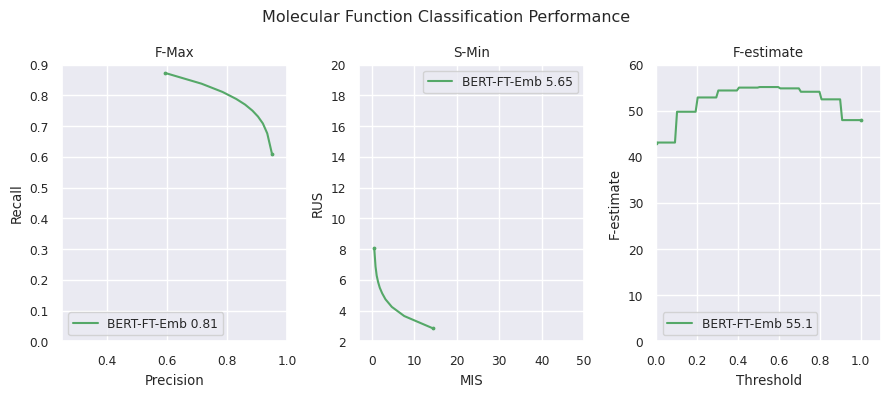

In [ ]:
def plot_curve(ax, x, y, **kwargs):
    ax.plot(x, y, **kwargs)
    ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3, c=kwargs['c'])

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
print(axes.shape)
fig.suptitle("Molecular Function Classification Performance")

base_models = ["BLAST", "Conv", "BERT-Emb", "BERT-FT", "Naive"]
disp_info = {
    "BLAST": colors[0],
    "Conv": colors[1],
    "BERT-Emb": colors[-1],
    "BERT-FT": colors[2],
    "Naive": colors[4]
}
for model_name in base_models:
    stats = model_stats[model_name]
    c = disp_info[model_name]
    precs, recs, f_scores, rms, mis, rus, s_vals = stats
    plot_curve(axes[0], precs, recs, label=f"{model_name} {round(max(f_scores), 2)}", c=c)
    axes[0].set_xlabel("Precision")
    axes[0].set_ylabel("Recall")

    plot_curve(axes[1], mis, rus, label=f"{model_name} {round(min(s_vals), 2)}", c=c)
    axes[1].set_xlabel("MIS")
    axes[1].set_ylabel("RUS")

    plot_curve(axes[2], np.linspace(0, 1, len(rms)), rms, label=f"{model_name} {round(max(rms), 1)}", c=c)
    axes[2].set_xlabel("Threshold")
    axes[2].set_ylabel("F-estimate")

axes[0].set_xlim([0.25, 1])
axes[0].set_ylim([0, 0.9])
axes[1].set_xlim([-3, 50])
axes[1].set_ylim([2, 20])
axes[2].set_xlim([0, 1.1])
axes[2].set_ylim([0, 60])

axes[0].set_title("F-Max")
axes[1].set_title("S-Min")
axes[2].set_title("F-estimate")

axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()
fig.show()

(3,)


/tmp/ipykernel_1369771/1243802358.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3, c=kwargs['c'])


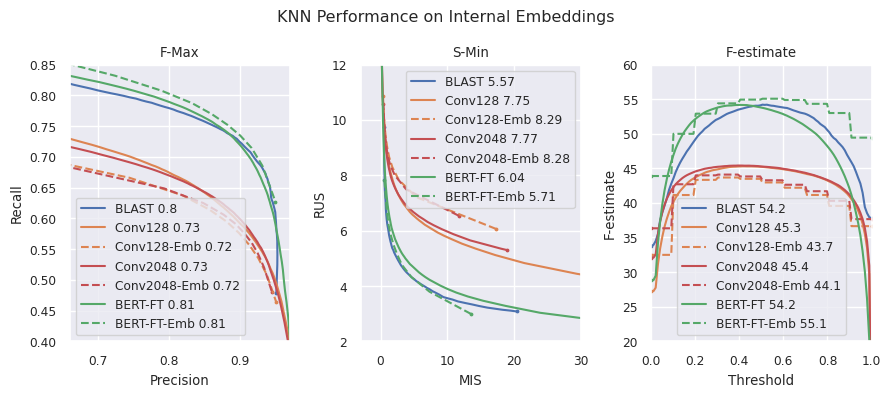

In [48]:
def plot_curve(ax, x, y, **kwargs):
    ax.plot(x, y, **kwargs)
    ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3, c=kwargs['c'])

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
print(axes.shape)
fig.suptitle("KNN Performance on Internal Embeddings")

disp_info = {
    "BLAST": (colors[0], 'solid'),
    "Conv128": (colors[1], 'solid'),
    "Conv128-Emb": (colors[1], 'dashed'),
    "Conv2048": (colors[3], 'solid'),
    "Conv2048-Emb": (colors[3], 'dashed'),
    "BERT-FT": (colors[2], 'solid'),
    "BERT-FT-Emb": (colors[2], 'dashed'),
}
base_models = ["BLAST", "Conv128", "Conv128-Emb", "Conv2048", "Conv2048-Emb", "BERT-FT", "BERT-FT-Emb"]
for model_name in base_models:
    stats = model_stats[model_name]
    c, lt = disp_info[model_name]
    precs, recs, f_scores, rms, mis, rus, s_vals = stats
    plot_curve(axes[0], precs, recs, label=f"{model_name} {round(max(f_scores), 2)}", c=c, linestyle=lt)
    plot_curve(axes[1], mis, rus, label=f"{model_name} {round(min(s_vals), 2)}", c=c, linestyle=lt)
    plot_curve(axes[2], np.linspace(0, 1, len(rms)), rms, label=f"{model_name} {round(max(rms), 1)}", c=c, linestyle=lt)
    
axes[0].set_xlabel("Precision")
axes[0].set_ylabel("Recall")
axes[1].set_xlabel("MIS")
axes[1].set_ylabel("RUS")
axes[2].set_xlabel("Threshold")
axes[2].set_ylabel("F-estimate")

axes[0].set_xlim([0.66, 0.97])
axes[0].set_ylim([0.4, 0.85])
axes[1].set_xlim([-3, 30])
axes[1].set_ylim([2, 12])
axes[2].set_xlim([0, 1])
axes[2].set_ylim([20, 60])

axes[0].set_title("F-Max")
axes[1].set_title("S-Min")
axes[2].set_title("F-estimate")

axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()
fig.show()

# Similarity Search

# Classify proteins with model
# Identify most similar proteins that support prediction in database


In [24]:
def get_embeddings(model, dataloader, device):
    prot_ids = []
    embed_list = []
    with torch.no_grad():
        for d in dataloader:
            prot_id_l = d["prot_ids"]
            X = d["seq"]
            prot_ids.extend(prot_id_l)
            X = X.to(device)
            embed = model.embedding(X)
            embed_list.append(embed)
    embeddings = torch.cat(embed_list, dim=0)
    return prot_ids, embeddings

In [31]:
from go_metric.models.bottleneck_dpg_conv import DPGModule
model = DPGModule.load_from_checkpoint("checkpoints/bottleneck_128.ckpt")
model.eval()
device = torch.device('cuda:1')
model.to(device)

_, train_emb = get_embeddings(model.model, train_loader, device)
_, val_emb = get_embeddings(model.model, val_loader, device)

In [15]:
import numpy as np
from scipy.sparse import csc_matrix

In [40]:
db_labels = csc_matrix(train_labels)
db_id, q_id = train_ids, val_ids
db_emb, q_emb = train_emb.cpu().numpy(), val_emb.cpu().numpy()

In [43]:
q_emb = q_emb[0, :]
db_dists = np.linalg.norm(db_emb - q_emb, axis=1)

In [44]:
val_ids, val_probs = get_sparse_probs(model, val_loader)

In [49]:
model_pred = val_probs[0, :].toarray()
terms = go_terms

In [54]:
db_sl = db_labels[:, pind].nonzero()[0]
q_pid = q_id[0]

In [61]:
model_cls = model_pred > 0.5
nz = model_cls.nonzero()[1]
pf_map = {}
for pind in nz:
    term = terms[pind]
    db_sl = db_labels[:, pind].nonzero()[0]
    db_sd = db_dists[db_sl]
    sim_db_ind = db_sl[np.argmin(db_sd)]
    sim_pid = db_id[sim_db_ind]
    pf_map[term] = sim_pid
print(nz)
print(q_pid)
print(pf_map)

[ 0  1  3 34 35 53]
Q9S9Z8
{'GO:0003674': 'Q20655', 'GO:0005488': 'Q20655', 'GO:0005515': 'Q20655', 'GO:1901265': 'P23367', 'GO:0000166': 'P23367', 'GO:0017076': 'P23367'}


In [64]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
tsne = TSNE()
tsne_emb = tsne.fit_transform(db_emb)
# pca = PCA()
# pca_emb = pca.fit_transform(db_emb)

/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


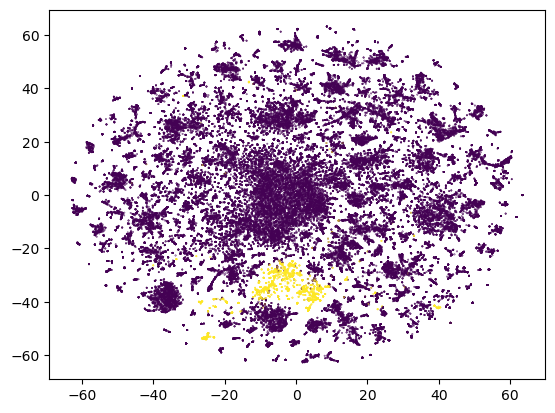

In [65]:
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], s=0.1, c=db_labels[:, 53].toarray().flatten())
plt.show()

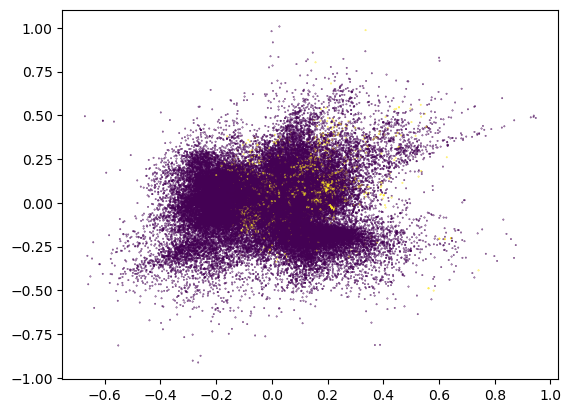

In [62]:
plt.scatter(pca_emb[:, 0], pca_emb[:, 1], s=0.1, c=db_labels[:, 53].toarray().flatten())
plt.show()